Installing the modules

In [267]:
!pip install openai python-dotenv langchain_community langchain-openai langchain-anthropic langchain matplotlib pandas seaborn plotly


[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Importing the needed modules

In [268]:
import pandas as pd
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.prompts import  HumanMessagePromptTemplate


# import the api key (The key name most be: `OPENAI_API_KEY`)
load_dotenv(dotenv_path='apikey.env')

True

Loading our dataset

In [269]:
product_sales_data = pd.read_csv("product_sales_dataset.csv")
product_sales_data.head()

,Date,Product_Category,Product_Name,Product_Cost,Product_Price,Items_Sold
0,2018-01-01,Art & Crafts,Barrel O' Slime,1.99,3.99,281
1,2018-01-01,Art & Crafts,Etch A Sketch,10.99,20.99,42
2,2018-01-01,Art & Crafts,Kids Makeup Kit,13.99,19.99,39
3,2018-01-01,Art & Crafts,Magic Sand,13.99,15.99,128
4,2018-01-01,Art & Crafts,PlayDoh Can,1.99,2.99,145


Lets calculate profit per product

In [270]:
def calculate_product_profit(df, price_col, cost_col, items_sold_col):
    df['Product_Profit'] = (df[price_col] - df[cost_col]) * df[items_sold_col]
    return df.reset_index()

product_sales_data = calculate_product_profit(product_sales_data, 'Product_Price', 'Product_Cost','Items_Sold')
product_sales_data.head()

,index,Date,Product_Category,Product_Name,Product_Cost,Product_Price,Items_Sold,Product_Profit
0,0,2018-01-01,Art & Crafts,Barrel O' Slime,1.99,3.99,281,562.0
1,1,2018-01-01,Art & Crafts,Etch A Sketch,10.99,20.99,42,420.0
2,2,2018-01-01,Art & Crafts,Kids Makeup Kit,13.99,19.99,39,234.0
3,3,2018-01-01,Art & Crafts,Magic Sand,13.99,15.99,128,256.0
4,4,2018-01-01,Art & Crafts,PlayDoh Can,1.99,2.99,145,145.0


Set up the LangChain connection to OpenAI

In [271]:
# set up the model
model = ChatOpenAI(temperature=0, model="gpt-4o")

Defining the LLM output structure using `pydantic`

In [272]:
class Code(BaseModel):
    """LLM Code output"""
    context: str = Field(description="Description of the generated code. and the input dataframe structure (column Names).")
    imports: str = Field(description="Code block import statements")
    code: str = Field(description="Code block not including import statements")
   

In [273]:
base_code = Code(
                context = """
                        We have a product sales dataset. Heres a description of the columns in this dataframe:
                        Date: The date on which the sales data for the products was recorded, formatted as YYYY-MM-DD.
                        Product_Category: The category to which the product belongs. This could include various categories like "Art & Crafts" or others.
                        Product_Name: The name of the product sold. Each row corresponds to a specific product such as "Barrel O' Slime" or "Etch A Sketch."
                        Product_Cost: The cost to produce or acquire the product. This is the amount spent on each unit of the product.
                        Product_Price: The selling price of the product. This is the price at which the product is sold to customers.
                        Items_Sold: The quantity of the product sold on the specified date.
                        Product_Profit: The total profit generated from the sales of the product. This value is the difference between the selling price and the product cost, multiplied by the number of items sold. It represents the gross profit from that product's sales.
                        Act like a data scientist and data visualization engineer. write a Python method called `generated_method` based on matplotlib to create a visualization based on user input.
                        The method should take a dataframe as input.
                """,
                imports="",
                code = """
                        def generated_method(dataframe):\n    pass
                """.strip(),
                 )

print(base_code.code)

def generated_method(dataframe):
    pass


In [274]:
def generate_code(codeObj, user_query):
    
    template = """
            {context}
            Here is the method:
            {imports}
            {code}
            Ensure any code you provide is using matplotlib and can be executed with all required imports and variables defined. Update the imports if needed.
            Structure your answer with a description of the code solution.
            Here is the user prompt:
            {user_prompt}
    """
    prompt_template = HumanMessagePromptTemplate.from_template(template = template)
    code_generation_prompt = prompt_template.format_messages(
                                                             context = codeObj.context,
                                                             imports = codeObj.imports, 
                                                             code = codeObj.code,
                                                             user_prompt = user_query, 
                                                             )
    
    chain = model.with_structured_output(Code)
    
    codeObj = chain.invoke(code_generation_prompt)
    return codeObj

def check_code(codeObj, user_prompt):
    code = codeObj.code + "\ngenerated_method(product_sales_data)"
    imports = codeObj.imports
    try:
        exec(imports, globals())
    except Exception as e:
        print("CODE NOT EXECUTABLE!")
        error_message = f"The following python method is not exectuable. there is the following error {e}. update the following method."
        new_context = codeObj.context + error_message + imports + code + "the user message is:" + user_prompt  
        codeObj.context = new_context
        print("---------------------------")
        print(codeObj.imports)
        return (codeObj, True)

    try:
        exec(code, globals())
    except Exception as e:
        print("CODE NOT EXECUTABLE!")
        error_message = f"The following python method is not exectuable. there is the following error {e}. update the following method."
        new_context = codeObj.context + error_message + "\n" + imports + "\n" + code + "\n" + "the user message is:" + user_prompt  
        codeObj.context = new_context
        print("---------------------------")
        print(codeObj.context)
        print(codeObj.imports)
        print(codeObj.code)
        return (codeObj, True)

    print("CODE IS EXECUTED WITH NO ERROR!")
    return (codeObj, False)

def install_needed_modules(imports):
    list = imports.split("\n")
    

def create_visualization(df, user_prompt):
    global base_code
    error = True
    attempt = 1
    while(error):
        print("Attempt:", attempt)
        base_code = generate_code(base_code, user_prompt)
        (base_code, error) = check_code(base_code, user_prompt)
        attempt += 1



Attempt: 1


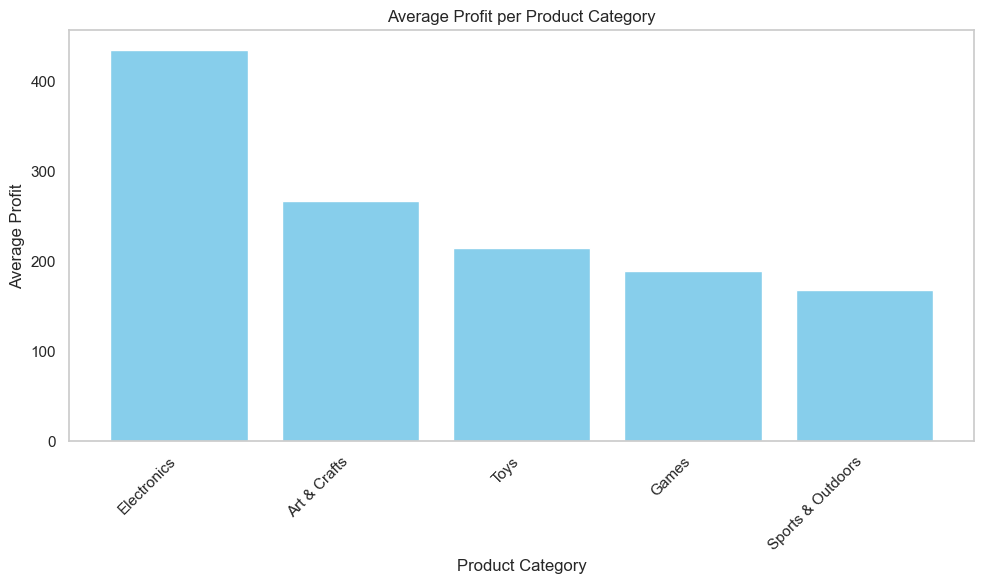

CODE IS EXECUTED WITH NO ERROR!


In [276]:
user_prompt = "remove the grid lines"
create_visualization(product_sales_data, user_prompt = user_prompt)